# An Introduction to Neural Networks (with an application to quantifiers in natural language)

This notebook is part of a tutorial, with accompanying slides.  We will develop a kind of _minimal working example_ of running an experiment with neural networks, inspired by work in natural language semantics.  Instructions for using this notebook may be found at https://github.com/shanest/nn-tutorial.  The slides also contain pointers to more advanced topics and applications.

In particular, we will conduct a very miniature version of one of the experiments in [Steinert-Threlkeld and Szymanik, "Learnability and Semantic Universals"](https://semanticsarchive.net/Archive/mQ2Y2Y2Z/LearnabilitySemanticUniversals.pdf).  In the figure below, they compare a monotone quantifier (_at least 4_) to a non-monotone one (_at least 6 or at most 2_), showing that the former is learned faster than the latter.  We will look at a similar pair of quantifiers here.

![](imgs/exp1a_acc.png)

(There are several important differences between what we will do today and what's done in the paper.  Because of time constraints, we won't do multiple trials or statistical analysis thereof, and we won't be using recurrent networks.)

## Generalized Quantifiers

Generalized quantifier theory provides the meanings for expressions like "most", "all", "between 5 and 10", etc. as they are used in sentences like

(1) Most of the students are happy.

(1) is true just in case the set of students who are happy outnumbers the set of students who are not happy.  Using interpretation bracket notation, where $\mathcal{M}$ is a model:

$$ [[ (1) ]]^{\mathcal{M}} = 1 \text{ iff } \textsf{card}([[\text{students}]] \cap [[\text{happy}]]) > \textsf{card}([[\text{students} \setminus \text{happy}]]) $$

We can view the meaning of an expression like "most" as a function, which takes as input models of the form $\mathcal{M} = \langle M, A, B \rangle$, where $A$ is the denotation of the restrictor (e.g. "students") and $B$ that of the nuclear scope (e.g. "are happy") and outputs a 1 or 0 based on the condition above.  

In other words, a quantifier is a _classifier_ of models, classifying every model as 1 (True) or 0 (False).

## Experiment

We will build a neural network classifier and train it to _learn_ different quantifiers.  Our goal will be to qualitatively compare _monotone_ (e.g. "most") to _non-monotone_ (e.g. "between 5 and 10") quantifiers.  Please refer to the paper linked above for full definitions of these concepts.

### Encoding the Input

We need a way of passing models into a neural network.  To do this, they must be represented as vectors of real numbers.  We will do this in the following way.

For convenience, we will assume properties known as Extensionality (EXT) and Conservativity (CONS) (see SEP for these definitions).  Together, these say that only the sets $A \cap B$ and $A \ B$ are relevant to the truth of a quantifier.  We can thus represent a model $\mathcal{M}$ by encoding whether each object in $M$ belongs to $A \cap B$ (in which case we will call it a $1$) or to $A \setminus B$ (in which case we will call it a $0$).

Thus, every model of size $n$ can be encoded as an $n$-dimensional vector of bits.  Conversely, every $n$-bit vector corresponds to a model $\mathcal{M}$.  (Subtle caveat: this correspondence requires an enumeration of $M$.  See the above paper for discussion.)

So we will consider models of a fixed size $N$, and feed our networks $N$-bit vectors.  It will output its guess as to whether the quantifier is true or false for that model.

### 0. Import Libraries

In [1]:
import itertools

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
from plotnine import *  # Python port of ggplot2

### 1. Define Parameters

In [2]:
params = {
    'model_size': 16,  # how big our models will be
    'num_epochs': 2,  # one epoch = one loop through the dataset
    'batch_size': 32,  # size of one batch of training examples
    'eval_every': 20,  # frequency of evaluations, in # of batches
}

Note: you will in general have more parameters when you do your experiments, and will usually want to pass these in to your program as command-line flags.  See [this repository]() for an example.

### 2. Generating the Data

First, we can use the Python module `itertools` to quickly generate all models of a certain size.

In [3]:
def get_all_models(length):
    """Returns a 2-D numpy array containing as rows all bit sequences of the specified length."""
    return np.array(list(
        itertools.product([0, 1], repeat=length)
    ))

get_all_models(3)

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

Our quantifiers will be functions from bit-arrays to truth values.

In [4]:
def most(model):
    return int(sum(model) > 0.5*len(model))  # integers are useful later

def between_m_n(model, m, n):
    return int(m < sum(model) < n)

`numpy` provides a nice method `apply_along_axis` that we can use to apply a quantifier to the array of all models generated by `get_all_models`.

In [5]:
def batch_apply(models, quantifier):
    """Applies quantifier function to 2-D array of models,
    where each row corresponds to one model."""
    return np.apply_along_axis(quantifier, 1, models)

batch_apply(get_all_models(3), most)

array([0, 0, 0, 1, 0, 1, 1, 1])

Shuffling the order of data is very important.  This method applies the same shuffle to two sequences, intuitively the inputs and the outputs of a given function.

In [6]:
def shuffle_data(models, labels):
    """Shuffles the order of an array of models and of labels."""
    assert len(models) == len(labels), "models and labels must be of same length"
    permutation = np.random.permutation(len(models))
    return models[permutation], labels[permutation]

We can put it all together: the method below takes in a model size and a quantifier function, and then generates the data, splits it into train/test sets (with a specified split percentage), shuffles it, and returns the two sets of data.

In [7]:
def get_data(model_size, quantifier, train_split=0.7, shuffle=True):
    """Gets training and test data for quantifier."""
    # get all models and labels
    models = get_all_models(model_size)
    labels = batch_apply(models, quantifier)
    # shuffle them
    if shuffle:
        models, labels = shuffle_data(models, labels)
    # split into train/test
    split_index = int(len(models) * train_split)  # int returns floor / rounds down
    train_models = models[:split_index]  # up to index, not including
    train_labels = labels[:split_index]
    test_models = models[split_index:]  # from index, including
    test_labels = labels[split_index:]
    return train_models, train_labels, test_models, test_labels

In [8]:
get_data(3, most)

(array([[1, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [1, 1, 1]]), array([1, 0, 0, 0, 1]), array([[0, 1, 1],
        [0, 0, 0],
        [1, 1, 0]]), array([1, 0, 1]))

### 3. Build Model

We will use the [PyTorch](http://pytorch.org) library for building and training neural networks.  This library -- developed at FAIR (Facebook AI Research) -- provides a very nice mix of scaffolding and flexibility, as well as great integration with basic Python control flow, which allows for rapid development of your ideas.

Models are always instances of new `class`es, which must always sub-class `nn.Module`.  By doing so, PyTorch will be able to automatically compute gradients for you, among other things.  

Note the first line in `__init__`: this call to `super(...).__init__` is very important!

The basic architecture of a model will be defined in the `__init__` method.  Here, we build a simple feed-forward network that has two hidden layers (`self.layer1` and `self.layer2`) and an output layer (`self.output`).

The _forward pass_ of your model, i.e. the actual network computation, is then defined in the `forward` method.  Note our standard recipe: `x = F.relu(self.layer(x))`.  This encapsulates the non-linear transformation (`F.relu`) applied point-wise to a linear transformation of the inputs to a layer.

Note that our `forward` method applies `softmax` at the output layer, to generate a probability distribution, as is common in classification tasks.

Note that you `forward` is very flexible: you can define it with any number of arguments, and return anything you want (including tuples, non-`torch.Tensor` objects, and so on).  

In [9]:
class FFNN(nn.Module):  # all models in PyTorch extend nn.Module
    
    def __init__(self, input_size, output_size):
        super(FFNN, self).__init__()
        
        self.layer1 = nn.Linear(input_size, 16)  # first hidden layer has 32 units
        self.layer2 = nn.Linear(16, 16)  # as does second
        self.output = nn.Linear(16, output_size)
        
    def forward(self, models):  # note: forward can take any number of arguments
        x = torch.as_tensor(models, dtype=torch.float)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)
        return F.softmax(x, dim=1)  # softmax converts to a probability distribution

### 4. Train Model

Before defining a complete training loop, let's just look at the model a little bit.

In [10]:
# get the data
train_models, train_labels, test_models, test_labels = get_data(
    params['model_size'],
    most
)
    
# get the model
model = FFNN(params['model_size'], 2)

Printing the model gives a nice overview of its structure.

In [11]:
model

FFNN(
  (layer1): Linear(in_features=16, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)

If you call `model` on some inputs, it calls `forward` on those inputs.  Note that we are sending a 2-D array here, with the first dimension being the number of example models, and the second dimension being the size of an individual model.  The output is a distribution over True/False for each example.

(While we could have had only one output node, since $p(False) = 1 - p(True)$, it's useful to treat this as a two-way classification task, to be more in line with classification tasks with more than two classes.)

In [12]:
model(train_models)

tensor([[0.3128, 0.6872],
        [0.3163, 0.6837],
        [0.2975, 0.7025],
        ...,
        [0.2862, 0.7138],
        [0.2872, 0.7128],
        [0.3283, 0.6717]], grad_fn=<SoftmaxBackward>)

We can now define the main training loop!  It's relatively straight-forward: get the training and test data, build the model, loop over epochs and mini-batches, performing one update for each mini-batch.

The update works like this in PyTorch: you instantiate an `optimizer`, with the parameters of your model.  Each mini-batch, you call `zero_grad` on the optimizer, in order to clear out its previous gradient computation.  After computing the loss, you can then compute all the gradients of all the parameters in the model by `loss.backward()`.  Note that here `loss` can be any `torch.Tensor` object!  Then, you simply call `opt.step()` to update the parameters!

We will also record some simple data during training so that we can visualize it.  This can also give you a feel for how you can store variables of interest while training a model.

In [13]:
# TODO: 
# * install pandas, plotnine
# * record data, plot learning curves

def train(params, quantifier, qname=None):
    
    # get the data
    train_models, train_labels, test_models, test_labels = get_data(
        params['model_size'],
        quantifier
    )
    
    # get the model
    model = FFNN(params['model_size'], 2)  # 2 outputs: False/True
    
    # get an optimizer
    opt = torch.optim.Adam(model.parameters())
    num_batches = int(len(train_models) / params['batch_size'])
    
    # dataframe to record
    data = {'training step': [], 'test accuracy': []}

    for epoch in range(params['num_epochs']):
        # shuffle the training data each epoch
        train_models, train_labels = shuffle_data(train_models, train_labels)
        model.train()  # for our model, this has no effect, but is good practice

        # individual training steps!
        for batch_idx in range(num_batches):
            # batch the data
            batch_models = train_models[batch_idx*params['batch_size']:(batch_idx+1)*params['batch_size']]
            batch_labels = train_labels[batch_idx*params['batch_size']:(batch_idx+1)*params['batch_size']]

            # get model's output
            model_probs = model(batch_models)  # calls .forward

            # zero the gradients
            opt.zero_grad()
            # calculate loss
            loss = F.cross_entropy(model_probs,
                                   torch.as_tensor(batch_labels))
            loss.backward()  # computes the gradients!
            opt.step()  # updates the parameters
            
            # get overall batch num for convenience
            batch_num = epoch*num_batches + batch_idx + 1
            if (batch_num + 1) % params['eval_every'] == 0:
                with torch.no_grad():  # speeds things up
                    model.eval()  # again, no effect on our model, but good practice
                    model_probs = model(test_models).numpy()
                    model_predictions = model_probs.argmax(axis=1).flatten()
                    # 1 if correct prediction, 0 otherwise
                    correct = (model_predictions == test_labels).astype(int)
                    accuracy = sum(correct) / len(correct)
                    print('Test set accuracy, after batch {}: {}'.format(
                        batch_num+1,
                        accuracy
                    ))
                    # record
                    data['training step'].append(batch_num+1)
                    data['test accuracy'].append(accuracy)
                model.train()
                
        data = pd.DataFrame(data)
        data['quantifier'] = qname or quantifier.__name__
        return data

In [14]:
most_data = train(params, most)

Test set accuracy, after batch 20: 0.5949341335639082
Test set accuracy, after batch 40: 0.595798789481715
Test set accuracy, after batch 60: 0.595798789481715
Test set accuracy, after batch 80: 0.595798789481715
Test set accuracy, after batch 100: 0.595798789481715
Test set accuracy, after batch 120: 0.595798789481715
Test set accuracy, after batch 140: 0.595798789481715
Test set accuracy, after batch 160: 0.595798789481715
Test set accuracy, after batch 180: 0.595798789481715
Test set accuracy, after batch 200: 0.595798789481715
Test set accuracy, after batch 220: 0.595798789481715
Test set accuracy, after batch 240: 0.595798789481715
Test set accuracy, after batch 260: 0.595798789481715
Test set accuracy, after batch 280: 0.595798789481715
Test set accuracy, after batch 300: 0.595798789481715
Test set accuracy, after batch 320: 0.595798789481715
Test set accuracy, after batch 340: 0.595798789481715
Test set accuracy, after batch 360: 0.595798789481715
Test set accuracy, after batch 

In [15]:
between_5_9_data = train(params, lambda model: between_m_n(model, 5, 9), qname='between 5 and 9')

Test set accuracy, after batch 20: 0.49142973399115
Test set accuracy, after batch 40: 0.5129952698235085
Test set accuracy, after batch 60: 0.568536697014394
Test set accuracy, after batch 80: 0.5787091195768272
Test set accuracy, after batch 100: 0.5197599308275266
Test set accuracy, after batch 120: 0.5003814658460912
Test set accuracy, after batch 140: 0.5014495702151467
Test set accuracy, after batch 160: 0.5344590814302426
Test set accuracy, after batch 180: 0.5196073444890901
Test set accuracy, after batch 200: 0.5881694725598902
Test set accuracy, after batch 220: 0.5752504959056
Test set accuracy, after batch 240: 0.515284064900056
Test set accuracy, after batch 260: 0.5372564976349118
Test set accuracy, after batch 280: 0.5654341081328519
Test set accuracy, after batch 300: 0.6717867860230914
Test set accuracy, after batch 320: 0.6840954173236357
Test set accuracy, after batch 340: 0.6195005340521845
Test set accuracy, after batch 360: 0.7010833630028992
Test set accuracy, af

### 5. A Small Visualization

We will now plot the data of one trial of training `most` and one trial of training `between 5 and 9`.  We'll put the number of training steps on the horizontal axis, and test set accuracy on the vertical axis.

We are using [`plotnine`](https://plotnine.readthedocs.io/en/stable/index.html) for plotting.  This is very faithful port to Python of Handley Wickham's `ggplot2` package for R.  This very influential package implements a "Grammar of Graphics" approach to generating figures.  For more information, you can check out the [Data Visualization](http://r4ds.had.co.nz/data-visualisation.html) chapter of _R for Data Science_, [this cheat sheet](https://github.com/rstudio/cheatsheets/blob/master/data-visualization-2.1.pdf), and more on [the package's website](https://ggplot2.tidyverse.org/).

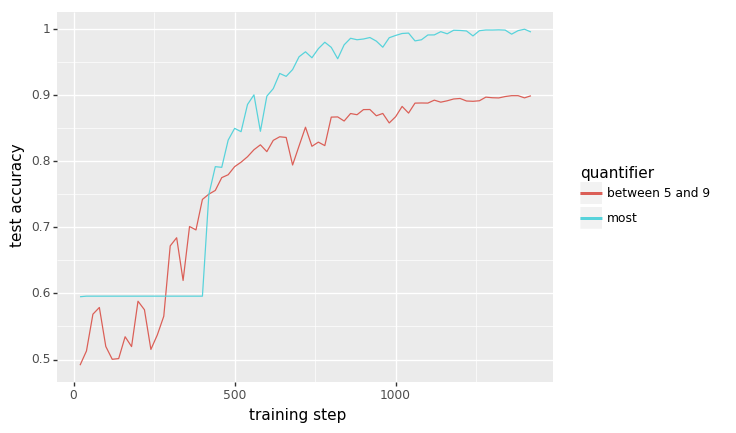

<ggplot: (-9223372036534111719)>

In [16]:
all_data = pd.concat([most_data, between_5_9_data])

(ggplot(all_data, aes(x='training step', y='test accuracy')) +
 geom_line(aes(colour='quantifier', group='quantifier')))

## Next Steps and Exercises

Very cool! It looks like the monotone quantifier is easier to learn than the non-monotone one.

Here are some ideas for things that you can do to continue to develop your skills with these tools:

1. Define more quantifiers, test them.
2. Make sure the training data is balanced.
3. Record data across trials, perform a statistical test to see whether one quantifier is learned faster than another.
4. Parameterize the network architecture, instead of hard-coding it in `__init__`.
5. Do a hyper-parameter search.
6. Modify the network (and data generation) so that it learns _multiple_ quantifiers at once.  HINT: you can assign the quantifiers IDs and pass them into `forward`.